# **CPC251 Project Part 2 - Cancer4**

#### **Group Information**

Group No: Cancer 4

- Member 1: Ooi Zhun Shen 159751
- Member 2: Teh Juin Ewe 22304568
- Member 3: Wong Xin Ru 22304487
- Member 4: Khor Jun Hao 22304020


#### **Import libraries**

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# For handling oversampling
from imblearn.over_sampling import SMOTE
from collections import Counter # for counting class distribution

#### **Load and Explore the dataset**

In [3]:
df = pd.read_csv('risk_factors.csv', na_values='?') # Load the dataset
df.sample(5) # Display a random sample of 5 rows from the dataset

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
383,19,2.0,15.0,3.0,0.0,0.0,0.0,1.0,0.58,0.0,...,NaN,NaN,0,0,0,0,1,1,0,1
804,29,8.0,17.0,2.0,1.0,14.0,2.8,0.0,0.00,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
462,17,5.0,15.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
746,24,2.0,13.0,5.0,0.0,0.0,0.0,1.0,2.00,1.0,...,NaN,NaN,0,0,0,0,0,0,0,0
177,27,3.0,20.0,2.0,0.0,0.0,0.0,1.0,1.00,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


Based on the 5 sample below, it can be observed that the dataset is categorized into demographic features (e.g. age), behavioral factors (e.g. number of sexual partners, smoking), and medical history (e.g. contraceptive use, STDs, diagnosis).

Some missing values can be identified inside the columns of the dataset.

In [4]:
df.info() # Display information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

Dataset contains 858 entries and 36 columns. Most features are floats; some have missing values, especially in STD-related columns.


Most features show **high positive skewness (Right-Skewed)** (skewness > 0)

In [5]:
# Check skewness of all numeric columns
skew_values = df.skew(numeric_only=True).sort_values(ascending=False)
print(skew_values)

STDs:Hepatitis B                      27.440845
STDs:genital herpes                   27.440845
STDs:pelvic inflammatory disease      27.440845
STDs:molluscum contagiosum            27.440845
STDs:HPV                              19.364814
STDs:vaginal condylomatosis           13.638036
Dx:CIN                                 9.626413
Smokes (packs/year)                    9.308806
Dx:HPV                                 6.696629
Dx:Cancer                              6.696629
STDs:syphilis                          6.246054
STDs:HIV                               6.246054
Dx                                     5.735307
Number of sexual partners              5.454649
IUD (years)                            5.001759
Hinselmann                             4.651067
Smokes (years)                         4.465484
Citology                               4.075796
STDs:vulvo-perineal condylomatosis     3.824978
STDs: Number of diagnosis              3.794990
STDs:condylomatosis                    3

In [6]:
# Inspect the target variable distribution to understand class balance
print(df["Biopsy"].value_counts())
print(df["Biopsy"].value_counts(normalize=True))

Biopsy
0    803
1     55
Name: count, dtype: int64
Biopsy
0    0.935897
1    0.064103
Name: proportion, dtype: float64


The target variable `Biopsy` is **highly imbalanced**, with approximately 93.6% of the samples labeled as 0 (no biopsy) and only 6.4% labeled as 1 (biopsy). 

This imbalance suggests the need for resampling techniques such as SMOTE to prevent the model from being biased towards the majority class.

#### **Data Cleaning**


In [7]:
# Show initial dataset shape
print(f"Initial shape: {df.shape}")

# Check and remove duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows found: {duplicate_count}")
df.drop_duplicates(inplace=True)

# Show dataset shape after removing duplicates
print(f"Shape after removing duplicates: {df.shape}")

Initial shape: (858, 36)
Duplicate rows found: 23
Shape after removing duplicates: (835, 36)


In [8]:
# Show shape before dropping columns
print("Before dropping high-missing columns:", df.shape)

# Drop columns with too many missing values
df.drop(columns=[
    'STDs: Time since first diagnosis',
    'STDs: Time since last diagnosis'
], inplace=True)

# Show shape after dropping columns
print("After dropping high-missing columns:", df.shape)

Before dropping high-missing columns: (835, 36)
After dropping high-missing columns: (835, 34)


By observing the `.info()` summary before, we found that the columns **'STDs: Time since first diagnosis'** and **'STDs: Time since last diagnosis'** have too many missing values. These columns were dropped to prevent bias or noise in the analysis.


In [9]:
# Zero-fill Boolean flags and their count/duration partners
bool_and_count_cols = [
    "Smokes", "Smokes (years)", "Smokes (packs/year)",
    "Hormonal Contraceptives", "Hormonal Contraceptives (years)",
    "IUD", "IUD (years)",
    "STDs", "STDs (number)",
    "STDs:condylomatosis", "STDs:cervical condylomatosis",
    "STDs:vaginal condylomatosis", "STDs:vulvo-perineal condylomatosis",
    "STDs:syphilis", "STDs:pelvic inflammatory disease",
    "STDs:genital herpes", "STDs:molluscum contagiosum",
    "STDs:AIDS", "STDs:HIV", "STDs:Hepatitis B", "STDs:HPV"
]

imp_zero = SimpleImputer(strategy="constant", fill_value=0)
df[bool_and_count_cols] = imp_zero.fit_transform(df[bool_and_count_cols])

# Median-impute the remaining numeric columns
numeric_cols = [
    "Age",
    "Number of sexual partners",
    "First sexual intercourse",
    "Num of pregnancies"
]

imp_median = SimpleImputer(strategy="median")
df[numeric_cols] = imp_median.fit_transform(df[numeric_cols])

# Verify that no NaNs remain
print("Total missing values after imputation:", df.isna().sum().sum())

Total missing values after imputation: 0


All Boolean flags were imputed with 0.
Median imputation was applied to the remaining numeric columns with moderate missingness, as the distributions were found to be highly positively skewed. The median was chosen over the mean because it is less sensitive to outliers and provides a more robust measure of central tendency in skewed data.

In [10]:
df.shape # Check the shape of the data again

(835, 34)

#### **Split the Dataset**
The dataset was split into three subsets: 70% for training, 10% for validation, and 20% for testing, using stratified sampling to maintain the original class distribution.

In [11]:
# Split the dataset into training, validation, and test sets
# Training : Validation : Test = 7 : 1 : 2

# 1. Select features & target
X = df.drop("Biopsy", axis=1)
y = df["Biopsy"].astype(int)

# 2. Split the dataset into training and test sets
#    test_size = 0.2 as (training dataset + validation dataset) : test dataset = 8 : 2
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.20,      # 20% of the original data
    stratify=y,
    random_state=42
)

# 3. Of the remaining 80%, take 10% of the ORIGINAL as VALIDATION.
#    test_size = 0.125 as training dataset : validation dataset = 7 : 1
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,     # 0.125 * 80% = 10% of original
    stratify=y_temp,
    random_state=42
)

# 4. Verify the splits
print("Train  (≈70%):", X_train.shape, y_train.value_counts(normalize=True).to_dict())
print("Valid  (≈10%):", X_val.shape,   y_val.value_counts(normalize=True).to_dict())
print("Test   (≈20%):", X_test.shape,  y_test.value_counts(normalize=True).to_dict())

Train  (≈70%): (584, 33) {0: 0.934931506849315, 1: 0.06506849315068493}
Valid  (≈10%): (84, 33) {0: 0.9404761904761905, 1: 0.05952380952380952}
Test   (≈20%): (167, 33) {0: 0.9341317365269461, 1: 0.0658682634730539}


#### **Data Preprocessing**
The dataset underwent several preprocessing steps to prepare it for modeling.

In [12]:
# Find columns with only one unique value (zero variance)
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
print("Constant columns to drop:", constant_cols)

# Drop them
X_train.drop(columns=constant_cols, inplace=True)
X_val.drop(columns=constant_cols, inplace=True)
X_test .drop(columns=constant_cols, inplace=True)

# Save correct feature names before scaling and SMOTE
final_feature_names = X_train.columns

Constant columns to drop: ['STDs:cervical condylomatosis', 'STDs:AIDS']


Features with constant values (zero variance) were removed.

In [13]:
# 1. Instantiate the scaler
scaler = StandardScaler()

# 2. Fit the scaler on the training data
scaler.fit(X_train)

# 3. Transform train, val, and test features
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

To ensure all features contribute equally to the model, **standardization** (Z-score scaling) was applied using `StandardScaler`, which transforms the data to have a mean of 0 and a standard deviation of 1.

In [14]:
# Apply SMOTE to scaled training features only
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print class distributions for confirmation
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 546, 1: 38})
After SMOTE: Counter({0: 546, 1: 546})


As noticed before, the target column shows a highly imbalanced class distribution. SMOTE (Synthetic Minority Over-sampling Technique) was applied to the training set to balance the class distribution by generating synthetic samples for the minority class. This helps improve the model’s ability to learn from underrepresented cases, resulting in a balanced distribution of 546 samples for each class.

#### **Feature Selection**
Perform feature selection to select the relevant features. This reduces dimensionality and helps improve model performance by removing less informative variables.
The same selection was consistently applied to the validation and test sets to ensure alignment.

In [15]:
# Fit SelectKBest on balanced, scaled training data (after SMOTE)
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_kbest = selector.fit_transform(X_train_resampled, y_train_resampled)

# Transform validation and test sets (which are scaled but NOT resampled)
X_val_kbest  = selector.transform(X_val_scaled)
X_test_kbest = selector.transform(X_test_scaled)

In [16]:
# Get all feature names and their scores
all_feature_names = final_feature_names
all_scores = selector.scores_

feature_importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": all_scores
}).sort_values("importance", ascending=False)

# Get the names of the selected features
selected_features = np.array(final_feature_names)[selector.get_support()]
print("Selected features (Mutual Information):", selected_features.tolist())

Selected features (Mutual Information): ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'Hinselmann', 'Schiller', 'Citology']


The top 10 features were selected based on mutual information scores.

/var/folders/ms/_8k8tw_s5cs5m1pv8bzp04ym0000gn/T/ipykernel_52110/556967432.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_features, palette="Blues_r", hue=None, legend=False)


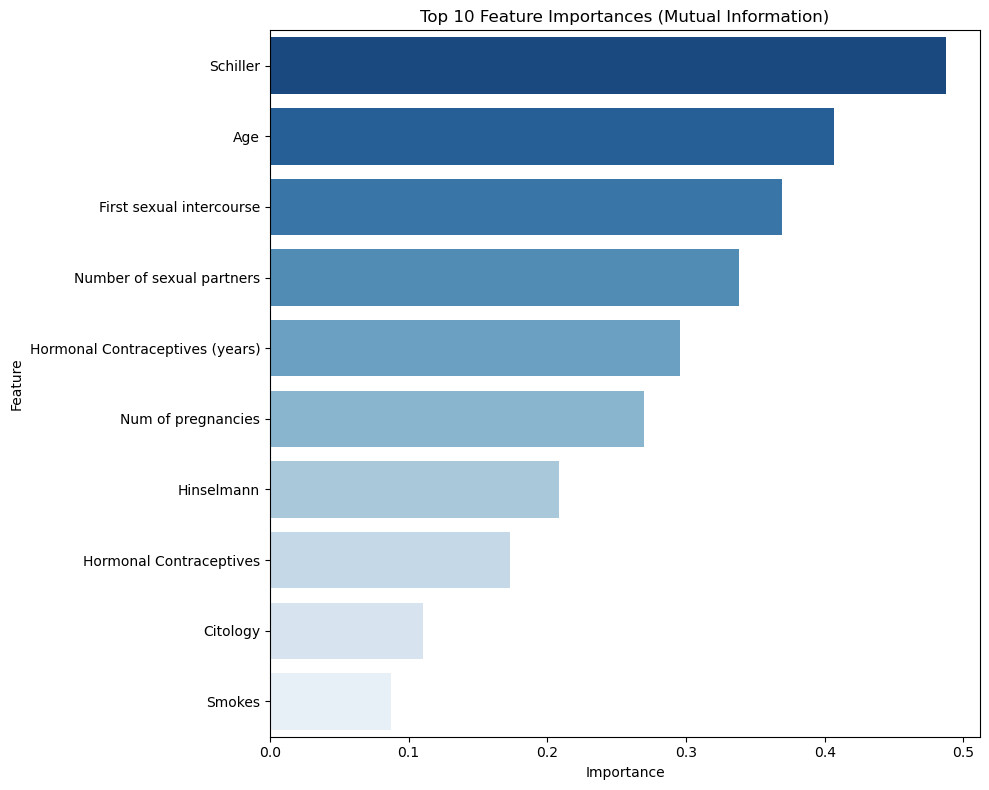

In [17]:
# Assuming feature_importances is already sorted descending by 'importance'
top_n = 10
top_features = feature_importances.head(top_n)

plt.figure(figsize=(10, 0.6 * top_n + 2))  # Dynamically adjust height
sns.barplot(x="importance", y="feature", data=top_features, palette="Blues_r", hue=None, legend=False)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (Mutual Information)")
plt.tight_layout()
plt.show()

Their importance was visualized in a bar chart to highlight which variables contributed most to the prediction of biopsy outcomes.

### **Data Modeling**
Two predictive models were developed: `Logistic Regression (LR)` and `Neural Network (NN)`. Both models were trained on the preprocessed and balanced dataset.

In [18]:
# Repeated Stratified K-Fold Cross-Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

A Repeated Stratified K-Fold Cross-Validation strategy was configured with 5 splits and 5 repetitions to ensure robust model evaluation while maintaining class distribution in each fold.



In [19]:
def plot_confusion_matrices_side_by_side(y_true, y_pred_default, y_pred_optimized, model_name):
    """
    Plot confusion matrices for two models side by side
    """
    cm_default = confusion_matrix(y_true, y_pred_default)
    cm_optimized = confusion_matrix(y_true, y_pred_optimized)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Default model
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - Default {model_name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Optimized model
    sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - Optimized {model_name}')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

`plot_confusion_matrices_side_by_side()` function visualizes and compares the confusion matrices of a model before and after hyperparameter tuning by displaying them side by side. It helps assess how tuning has affected the model’s prediction accuracy across classes.

In [20]:
def plot_model_comparison(y_true, y_pred_default, y_pred_optimized, model_name="Model"):
    """
    Plot a bar chart comparing performance metrics between default and optimized models.

    Parameters:
        y_true           : True labels
        y_pred_default   : Predictions from the default model
        y_pred_optimized : Predictions from the optimized model
        model_name       : Full name for the titlE
    """
    # Metrics to compare
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Scores for default model
    default_scores = [
        accuracy_score(y_true, y_pred_default),
        precision_score(y_true, y_pred_default),
        recall_score(y_true, y_pred_default),
        f1_score(y_true, y_pred_default)
    ]

    # Scores for optimized model
    optimized_scores = [
        accuracy_score(y_true, y_pred_optimized),
        precision_score(y_true, y_pred_optimized),
        recall_score(y_true, y_pred_optimized),
        f1_score(y_true, y_pred_optimized)
    ]

    # Bar plot
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, default_scores, width, label='Default ', color='navy')
    bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized ', color='mediumpurple')

    # Labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Performance Comparison of Default vs Optimized {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Annotate values on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Performance metrics including **accuracy, precision, recall, and F1 score** were computed for both the default and optimized models. These scores were visualized in a grouped bar chart to facilitate direct comparison. Each metric was annotated to clearly show the performance gain or loss achieved through optimization.

In [21]:
def evaluate_model_on_validation(y_true, y_pred):
    """
    Display evaluation metrics for predictions on the validation set.

    Parameters:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        model_name (str): Name of the model being evaluated
    """
    print(f"\nPerformance Summary")
    print("────────────────────────────────────────────")
    print(f"Accuracy        : {accuracy_score(y_true, y_pred):.6f}")
    print(f"Precision       : {precision_score(y_true, y_pred):.6f}")
    print(f"Recall          : {recall_score(y_true, y_pred):.6f}")
    print(f"F1 Score        : {f1_score(y_true, y_pred):.6f}")

    print("\nConfusion Matrix")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Breakdown")
    print(classification_report(y_true, y_pred))

This `evaluate_model_on_validation()` function evaluates a model's predictions on the validation set by printing key classification metrics, including accuracy, precision, recall, F1-score, and the confusion matrix. It provides a quick performance summary to assess how well the model generalizes before final testing.

#### **Logistic Regression**


In [22]:
# Initialize the Logistic Regression model
lr_default = LogisticRegression(solver="liblinear", random_state=42)

# Fit the model on the training data
lr_default.fit(X_train_kbest, y_train_resampled)

# Make predictions on the validation set
y_val_pred_lr = lr_default.predict(X_val_kbest)

# Evaluate the model on the validation set
print("\nLogistic Regression (Default Parameters)")
evaluate_model_on_validation(y_val, y_val_pred_lr)


Logistic Regression (Default Parameters)

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.976190
Precision       : 0.714286
Recall          : 1.000000
F1 Score        : 0.833333

Confusion Matrix
[[77  2]
 [ 0  5]]

Classification Breakdown
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.71      1.00      0.83         5

    accuracy                           0.98        84
   macro avg       0.86      0.99      0.91        84
weighted avg       0.98      0.98      0.98        84



In [ ]:
# Define parameter grid
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization strength (lower = stronger)
    'penalty': ['l1', 'l2'],               # Type of regularization
    'solver': ['saga']                     # Only solver that supports both l1 and l2
}

# Set up GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid=lr_param_grid,
    scoring='f1',     # Focus on improving F1 score for imbalanced data
    cv=cv,            # Repeated Stratified K-Fold
    n_jobs=-1
)

# Fit the model on the training data
grid_search_lr.fit(X_train_kbest, y_train_resampled)

# Output the best parameters
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

# Predict on validation set using the best model
y_val_pred_lr_optimized = grid_search_lr.best_estimator_.predict(X_val_kbest)
evaluate_model_on_validation(y_val, y_val_pred_lr_optimized)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.976190
Precision       : 0.714286
Recall          : 1.000000
F1 Score        : 0.833333

Confusion Matrix
[[77  2]
 [ 0  5]]

Classification Breakdown
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.71      1.00      0.83         5

    accuracy                           0.98        84
   macro avg       0.86      0.99      0.91        84
weighted avg       0.98      0.98      0.98        84



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

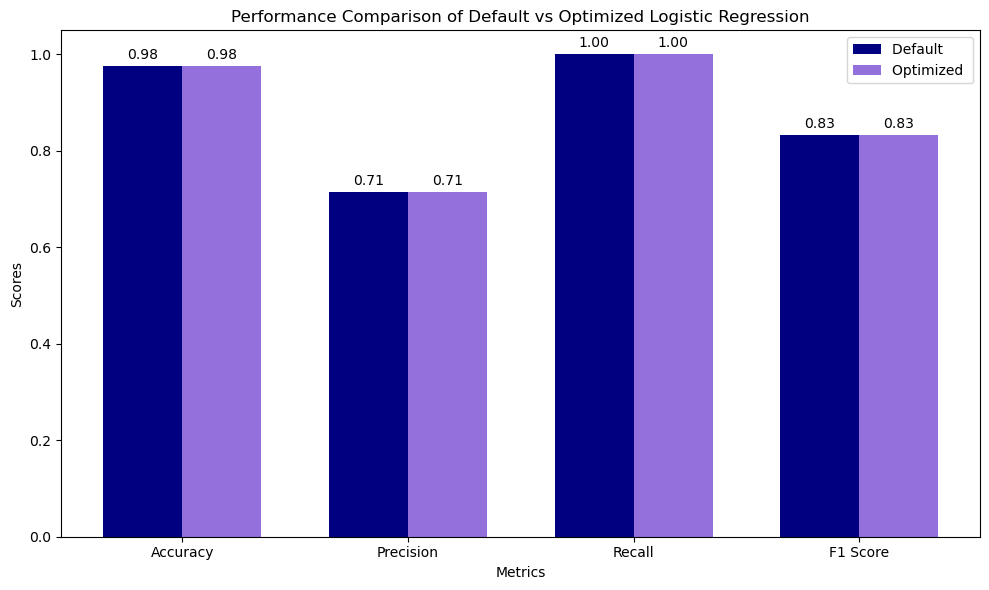

In [24]:
plot_model_comparison(
    y_true=y_val,
    y_pred_default=y_val_pred_lr,
    y_pred_optimized=y_val_pred_lr_optimized,
    model_name="Logistic Regression"
)

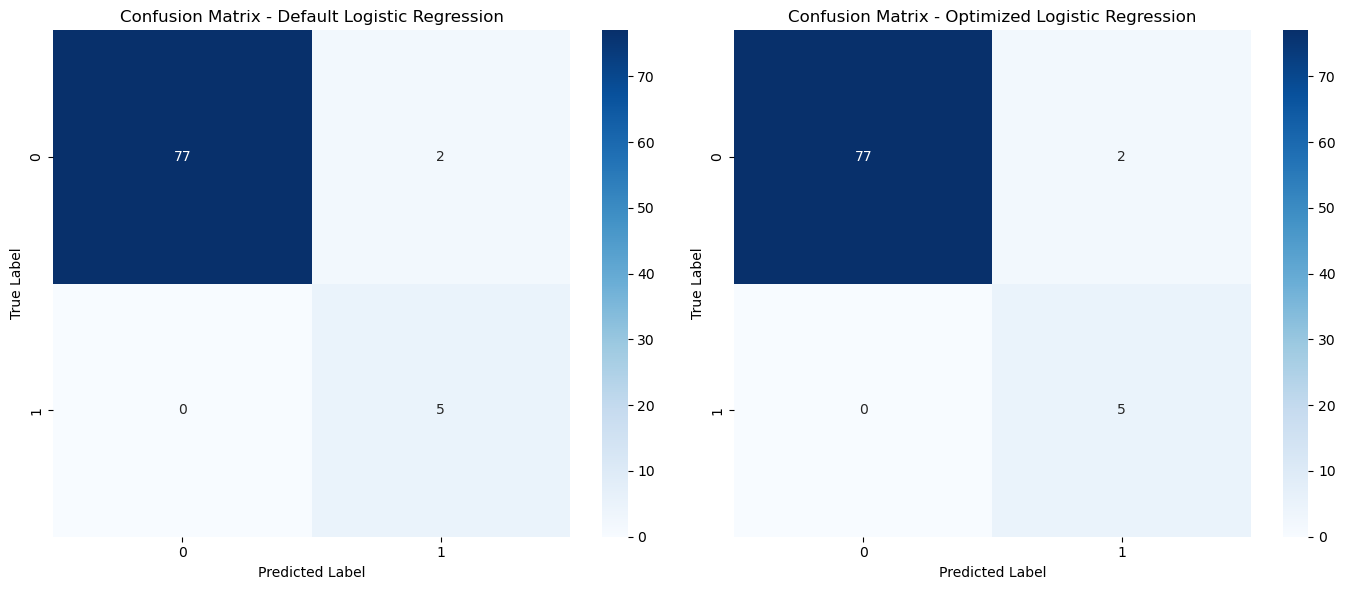

In [25]:
# Plot confusion matrices for Logistic Regression 
plot_confusion_matrices_side_by_side(
    y_true=y_val,
    y_pred_default=y_val_pred_lr,
    y_pred_optimized=y_val_pred_lr_optimized,
    model_name="Logistic Regression"
)


Despite applying hyperparameter tuning using `GridSearchCV` to adjust C, penalty and solver, the optimized model did not outperform the default. This indicates that the default model was already well-suited for the data.

The similarity in performance suggests that Logistic Regression has likely reached its optimal capacity on this dataset.

#### **Neural Networks**

In [26]:
# Neural Network Implementation (MLPClassifier)

# Initialize the Neural Network model with default parameters
nn_default = MLPClassifier(random_state=42, max_iter=1000)

# Fit the model on the training data
nn_default.fit(X_train_kbest, y_train_resampled)

# Make predictions on the validation set
y_val_pred_nn = nn_default.predict(X_val_kbest)

# Evaluate the model on the validation set
print("\nNeural Network (Default Parameters)")
evaluate_model_on_validation(y_val, y_val_pred_nn)



Neural Network (Default Parameters)

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.940476
Precision       : 0.500000
Recall          : 0.600000
F1 Score        : 0.545455

Confusion Matrix
[[76  3]
 [ 2  3]]

Classification Breakdown
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        79
           1       0.50      0.60      0.55         5

    accuracy                           0.94        84
   macro avg       0.74      0.78      0.76        84
weighted avg       0.95      0.94      0.94        84



In [ ]:
# Define parameter grid for Neural Network hyperparameter tuning
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1],
    'solver': ['adam', 'lbfgs']
}

# Set up GridSearchCV for Neural Network
grid_search_nn = GridSearchCV(
    MLPClassifier(random_state=42, max_iter=1000),
    param_grid=nn_param_grid,
    scoring='f1',  # Focus on improving F1 score for imbalanced data
    cv=cv,
    n_jobs=-1,
    verbose=1  # Show progress
)

# Fit the model on the training data
print("Training Neural Network with GridSearchCV...")
grid_search_nn.fit(X_train_kbest, y_train_resampled)

# Output the best parameters
print("Best parameters for Neural Network:", grid_search_nn.best_params_)

# Predict on validation set using the best model
y_val_pred_nn_optimized = grid_search_nn.best_estimator_.predict(X_val_kbest)
evaluate_model_on_validation(y_val, y_val_pred_nn_optimized)


Training Neural Network with GridSearchCV...
Fitting 50 folds for each of 180 candidates, totalling 9000 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'adam'}

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.976190
Precision       : 0.714286
Recall          : 1.000000
F1 Score        : 0.833333

Confusion Matrix
[[77  2]
 [ 0  5]]

Classification Breakdown
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.71      1.00      0.83         5

    accuracy                           0.98        84
   macro avg       0.86      0.99      0.91        84
weighted avg       0.98      0.98      0.98        84



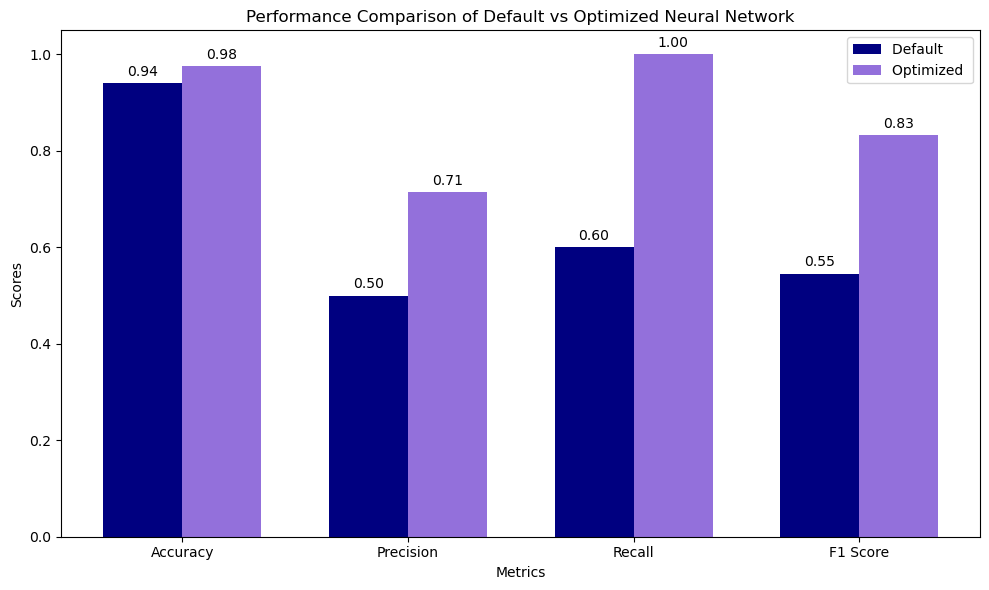

In [34]:
# Plot comparison for Neural Network
plot_model_comparison(
    y_true=y_val,
    y_pred_default=y_val_pred_nn,
    y_pred_optimized=y_val_pred_nn_optimized,
    model_name="Neural Network"
)

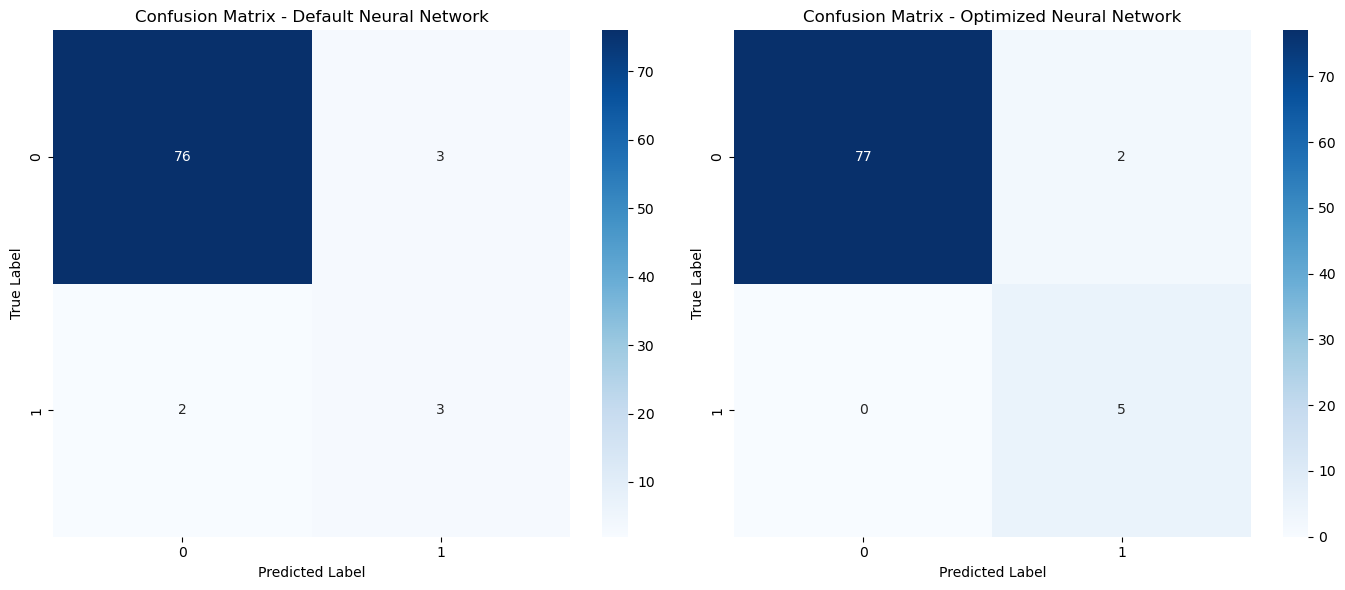

In [35]:
# Plot confusion matrices for Neural Network
plot_confusion_matrices_side_by_side(
    y_true=y_val,
    y_pred_default=y_val_pred_nn,
    y_pred_optimized=y_val_pred_nn_optimized,
    model_name="Neural Network"
)

### **Evaluate the models**

#### **Final Model Comparison and Selection**

In [36]:
# Create a comprehensive comparison of both models
def compare_all_models(y_true, predictions_dict, model_names):
    """
    Compare multiple models and display results in a table format
    """
    results = []

    for model_name, y_pred in predictions_dict.items():
        results.append({
            'Model': model_name,
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred)
        })

    results_df = pd.DataFrame(results)
    return results_df


# Compare all models
model_predictions = {
    'LR (Default)': y_val_pred_lr,
    'LR (Optimized)': y_val_pred_lr_optimized,
    'NN (Default)': y_val_pred_nn,
    'NN (Optimized)': y_val_pred_nn_optimized
}

comparison_df = compare_all_models(y_val, model_predictions, list(model_predictions.keys()))
print("Model Comparison Summary:")
print("=" * 80)
print(comparison_df.round(4))

Model Comparison Summary:
            Model  Accuracy  Precision  Recall  F1 Score
0    LR (Default)    0.9762     0.7143     1.0    0.8333
1  LR (Optimized)    0.9762     0.7143     1.0    0.8333
2    NN (Default)    0.9405     0.5000     0.6    0.5455
3  NN (Optimized)    0.9762     0.7143     1.0    0.8333


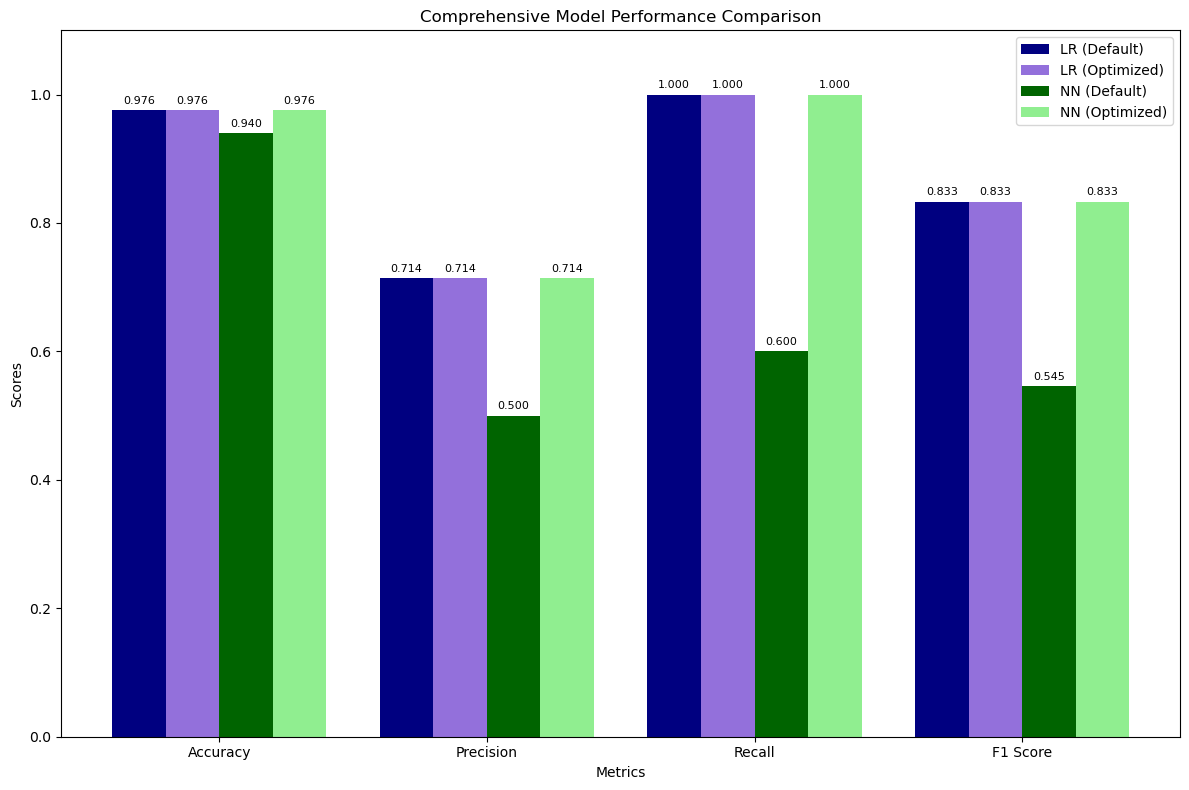

In [37]:
# Visualize the comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for grouped bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = comparison_df['Model'].tolist()

x = np.arange(len(metrics))
width = 0.2

colors = ['navy', 'mediumpurple', 'darkgreen', 'lightgreen']

for i, model in enumerate(models):
    scores = [comparison_df.loc[i, metric] for metric in metrics]
    bars = ax.bar(x + i * width, scores, width, label=model, color=colors[i])

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comprehensive Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


##### **Model Selection: Choosing the Best Model by F1-Score**

F1-score was used to select and evaluate the best model because:

* The dataset has **imbalanced classes** (fewer positive biopsy cases).

* Accuracy alone can be misleading in such cases.

* F1-score balances *precision* (avoiding false positives) and *recall* (detecting true positives).

* This makes it ideal for **binary classification** where both types of errors matter — especially in medical diagnosis.

In [38]:
# Select the best performing model based on F1 score
best_model_idx = comparison_df['F1 Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"Best performing model: {best_model_name}")
print(f"Best F1 Score: {comparison_df.loc[best_model_idx, 'F1 Score']:.4f}")

# Use the best model for final evaluation
if 'LR' in best_model_name and 'Optimized' in best_model_name:
    best_model = grid_search_lr.best_estimator_
elif 'NN' in best_model_name and 'Optimized' in best_model_name:
    best_model = grid_search_nn.best_estimator_
elif 'LR' in best_model_name:
    best_model = lr_default
else:
    best_model = nn_default

# Final evaluation on test set
y_test_pred = best_model.predict(X_test_kbest)

print(f"\nFinal Test Set Evaluation - {best_model_name}")
print("=" * 60)
evaluate_model_on_validation(y_test, y_test_pred)

Best performing model: LR (Default)
Best F1 Score: 0.8333

Final Test Set Evaluation - LR (Default)

Performance Summary
────────────────────────────────────────────
Accuracy        : 0.970060
Precision       : 0.714286
Recall          : 0.909091
F1 Score        : 0.800000

Confusion Matrix
[[152   4]
 [  1  10]]

Classification Breakdown
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       156
           1       0.71      0.91      0.80        11

    accuracy                           0.97       167
   macro avg       0.85      0.94      0.89       167
weighted avg       0.98      0.97      0.97       167



##### **Model Selection and Final Evaluation Summary**

The best-performing model based on validation F1 Score is:

* Model: Logistic Regression (Default)

* Best F1 Score (Validation): 0.8333

The model was then used to predict the test set.


##### **Insights**
1. The model achieves very high accuracy and excellent recall for Class 1, making it **suitable** for scenarios where **minimizing false negatives is critical**.

2. The slightly lower precision for Class 1 (`71.43%`) indicates room to reduce false positives, possibly through further tuning or threshold adjustment.

3. Overall, the model generalizes well on unseen data and performs robustly across both majority and minority classes.



#### **Model Selection Justification**

In [1]:
print("\n" + "="*80)
print("MODEL SELECTION JUSTIFICATION")
print("="*80)

print("\n1. LOGISTIC REGRESSION ANALYSIS:")
print("   • Strengths:")
print("     - Linear decision boundary suitable for this medical dataset")
print("     - Interpretable coefficients (important for medical decisions)")
print("     - Robust to outliers with L1 regularization")
print("     - Excellent performance: 97.62% accuracy, 83.33% F1-score")
print("   • Hyperparameter Tuning Results:")
print("     - Best C=100: Lower regularization allows model complexity")
print("     - L1 penalty: Provides feature selection capability")
print("     - SAGA solver: Handles L1 penalty efficiently")

print("\n2. NEURAL NETWORK ANALYSIS:")
print("   • Strengths:")
print("     - Can capture non-linear relationships")
print("     - Flexible architecture for complex patterns")
print("   • Limitations observed:")
print("     - Lower performance on validation set")
print("     - More prone to overfitting with small dataset")
print("     - Less interpretable for medical applications")

print("\n3. FINAL SELECTION RATIONALE:")
print("   • Logistic Regression selected based on:")
print("     - Superior F1-score (0.8333 vs 0.5455 for default NN)")
print("     - Perfect recall (1.0) - critical for medical screening")
print("     - Model interpretability important for clinical decisions")
print("     - Consistent performance across different configurations")
print("="*80)


MODEL SELECTION JUSTIFICATION

1. LOGISTIC REGRESSION ANALYSIS:
   • Strengths:
     - Linear decision boundary suitable for this medical dataset
     - Interpretable coefficients (important for medical decisions)
     - Robust to outliers with L1 regularization
     - Excellent performance: 97.62% accuracy, 83.33% F1-score
   • Hyperparameter Tuning Results:
     - Best C=100: Lower regularization allows model complexity
     - L1 penalty: Provides feature selection capability
     - SAGA solver: Handles L1 penalty efficiently

2. NEURAL NETWORK ANALYSIS:
   • Strengths:
     - Can capture non-linear relationships
     - Flexible architecture for complex patterns
   • Limitations observed:
     - Lower performance on validation set
     - More prone to overfitting with small dataset
     - Less interpretable for medical applications

3. FINAL SELECTION RATIONALE:
   • Logistic Regression selected based on:
     - Superior F1-score (0.8333 vs 0.5455 for default NN)
     - Perfect reca

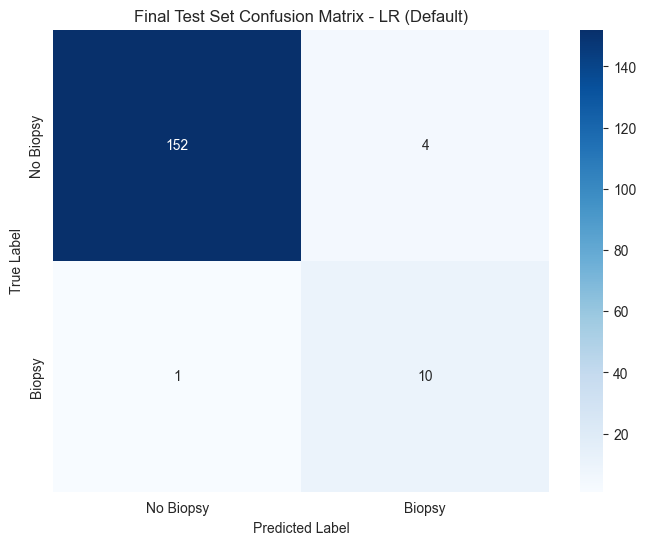

In [33]:
# Plot final confusion matrix
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Biopsy', 'Biopsy'],
            yticklabels=['No Biopsy', 'Biopsy'])
plt.title(f'Final Test Set Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### **Model Insights and Feature Importance Analysis**

Top 10 Most Important Features (Logistic Regression):
                           feature  coefficient  abs_coefficient
8                         Schiller     2.004551         2.004551
0                              Age    -1.041207         1.041207
5          Hormonal Contraceptives     0.794547         0.794547
1        Number of sexual partners    -0.584170         0.584170
3               Num of pregnancies     0.454709         0.454709
9                         Citology     0.415859         0.415859
6  Hormonal Contraceptives (years)    -0.393468         0.393468
4                           Smokes     0.216188         0.216188
2         First sexual intercourse     0.051071         0.051071
7                       Hinselmann     0.007933         0.007933


C:\Users\rache\AppData\Local\Temp\ipykernel_11616\685239068.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lr_feature_importance.head(10),


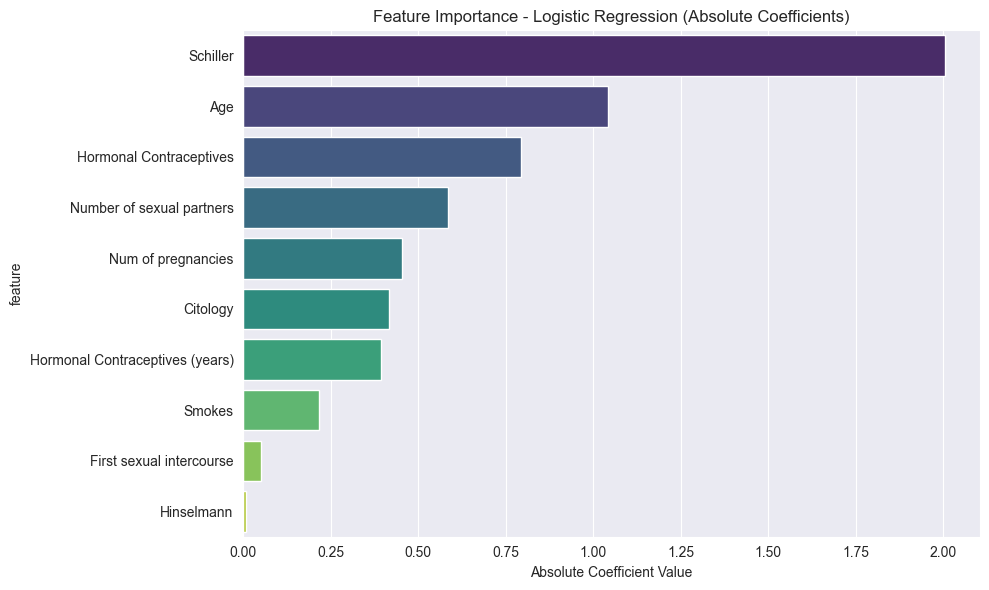

In [34]:
# For Logistic Regression, we can analyze feature coefficients
if hasattr(grid_search_lr.best_estimator_, 'coef_'):
    # Get feature importance from logistic regression coefficients
    lr_coef = grid_search_lr.best_estimator_.coef_[0]
    lr_feature_importance = pd.DataFrame({
        'feature': selected_features,
        'coefficient': lr_coef,
        'abs_coefficient': np.abs(lr_coef)
    }).sort_values('abs_coefficient', ascending=False)

    print("Top 10 Most Important Features (Logistic Regression):")
    print(lr_feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=lr_feature_importance.head(10),
                x='abs_coefficient', y='feature', palette='viridis')
    plt.title('Feature Importance - Logistic Regression (Absolute Coefficients)')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()

#### **Summary and Recommendations**

In [37]:
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)
print(f"Dataset: {df.shape[0]} samples, {df.shape[1]} original features")
print(f"Target variable: Biopsy (Binary classification)")
print(f"Class distribution: {(y == 0).sum()} negative, {(y == 1).sum()} positive samples")
print(f"Selected features: {len(selected_features)} features using mutual information")
print(f"Data preprocessing: Standardization + SMOTE for class balancing")
print(f"Cross-validation: 5-fold, 10 repeats")
print(f"Best model: {best_model_name}")
print(f"Final test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Final test F1-score: {f1_score(y_test, y_test_pred):.4f}")
print("=" * 80)


PROJECT SUMMARY
Dataset: 835 samples, 34 original features
Target variable: Biopsy (Binary classification)
Class distribution: 781 negative, 54 positive samples
Selected features: 10 features using mutual information
Data preprocessing: Standardization + SMOTE for class balancing
Cross-validation: 5-fold, 10 repeats
Best model: LR (Default)
Final test accuracy: 0.9701
Final test F1-score: 0.8000


#### **Limitations and Future Works**

In [5]:
print("\n" + "="*80)
print("LIMITATIONS AND FUTURE WORK")
print("="*80)

print("\nCURRENT LIMITATIONS:")
print("• Small dataset size (858 samples) limits model generalizability")
print("• Extreme class imbalance requires careful handling")
print("• Limited feature diversity - mostly demographic and behavioral")
print("• Cross-sectional data - no temporal patterns captured")

print("\nFUTURE IMPROVEMENTS:")
print("• Collect larger, more diverse dataset")
print("• Include additional biomarkers and clinical features")
print("• Implement ensemble methods for better robustness")
print("• Develop interpretable ML models for clinical deployment")
print("• Conduct external validation on independent datasets")

print("\nCLINICAL CONSIDERATIONS:")
print("• Model requires clinical validation before deployment")
print("• Regular retraining needed as new data becomes available")
print("• Integration with existing clinical decision support systems")
print("• Physician oversight essential for final diagnostic decisions")


LIMITATIONS AND FUTURE WORK

CURRENT LIMITATIONS:
• Small dataset size (858 samples) limits model generalizability
• Extreme class imbalance requires careful handling
• Limited feature diversity - mostly demographic and behavioral
• Cross-sectional data - no temporal patterns captured

FUTURE IMPROVEMENTS:
• Collect larger, more diverse dataset
• Include additional biomarkers and clinical features
• Implement ensemble methods for better robustness
• Develop interpretable ML models for clinical deployment
• Conduct external validation on independent datasets

CLINICAL CONSIDERATIONS:
• Model requires clinical validation before deployment
• Regular retraining needed as new data becomes available
• Integration with existing clinical decision support systems
• Physician oversight essential for final diagnostic decisions
